# Introduction do deep learning for computer vision

## Imports

In [1]:
import os, shutil, pathlib

import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

import matplotlib.pyplot as plt
from plot_utils import plot_history

from tqdm import tqdm

print(f"{tf.__version__ = }")

tf.__version__ = '2.6.1'


## Introduction to covnets

In [2]:
def build_covnet():
    inputs = keras.Input(shape=(28, 28, 1))

    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(10, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model = build_covnet()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0     

2022-05-02 00:38:37.631576: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-02 00:38:38.184441: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10801 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7


In [3]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60_000, 28, 28, 1)).astype("float32") / 255
test_images = test_images.reshape((10_000, 28, 28, 1)).astype("float32") / 255

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"{test_acc = :.3f}")

11501568/11490434 [==============================] - 0s 0us/step


2022-05-02 00:38:39.547220: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-05-02 00:38:40.469124: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8302


938/938 [==============================] - 6s 5ms/step - loss: 0.1582 - accuracy: 0.9512
Epoch 2/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0455 - accuracy: 0.9859
Epoch 3/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0318 - accuracy: 0.9898
Epoch 4/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0244 - accuracy: 0.9922
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0299 - accuracy: 0.9914
test_acc = 0.991


## Training a covnet from scratch on a small dataset

### Pepare the dataset

In [4]:
home_dir = pathlib.Path.home()
original_dir= home_dir / "data/dogs-vs-cats/train"
new_base_dir = home_dir / "data/dogs-vs-cats-small"

In [5]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dst = new_base_dir / subset_name / category
        dst.mkdir(parents=True, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]

        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst= dst / fname)

make_subset("train", start_index=0, end_index=1_000)
make_subset("validation", start_index=1_000, end_index=1_500)
make_subset("test", start_index=1_500, end_index=2_500)

In [6]:
!ls -1 {new_base_dir}/train/cat | wc -l
!ls -1 {new_base_dir}/validation/cat | wc -l
!ls -1 {new_base_dir}/test/cat | wc -l

1000
500
1000


In [7]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)

# add 4 groups of conv-pool
for f in [32, 64, 128, 256]:
    x = layers.Conv2D(filters=f, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)

# add 1 mere conv and flatten
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 41, 41, 128)       7385

In [8]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [9]:
train_dataset = image_dataset_from_directory(new_base_dir / "train", image_size=(180, 180), batch_size=32)
validation_dataset = image_dataset_from_directory(new_base_dir / "validation", image_size=(180, 180), batch_size=32)
test_dataset = image_dataset_from_directory(new_base_dir / "test", image_size=(180, 180), batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [10]:
for image_batch, labels_batch in train_dataset.take(1):
    print(f"{image_batch.shape = }")
    print(f"{labels_batch.shape = }")

image_batch.shape = TensorShape([32, 180, 180, 3])
labels_batch.shape = TensorShape([32])


Epoch 1/30
63/63 [==============================] - 9s 108ms/step - loss: 0.7000 - accuracy: 0.5180 - val_loss: 0.6859 - val_accuracy: 0.5620
Epoch 2/30
63/63 [==============================] - 6s 92ms/step - loss: 0.6841 - accuracy: 0.5915 - val_loss: 0.6550 - val_accuracy: 0.6040
Epoch 3/30
63/63 [==============================] - 6s 93ms/step - loss: 0.6625 - accuracy: 0.6525 - val_loss: 0.6339 - val_accuracy: 0.6630
Epoch 4/30
63/63 [==============================] - 6s 93ms/step - loss: 0.6161 - accuracy: 0.6760 - val_loss: 0.6235 - val_accuracy: 0.6370
Epoch 5/30
63/63 [==============================] - 6s 94ms/step - loss: 0.5650 - accuracy: 0.7135 - val_loss: 0.6585 - val_accuracy: 0.6730
Epoch 6/30
63/63 [==============================] - 6s 94ms/step - loss: 0.5212 - accuracy: 0.7495 - val_loss: 0.5570 - val_accuracy: 0.7030
Epoch 7/30
63/63 [==============================] - 6s 94ms/step - loss: 0.4633 - accuracy: 0.7785 - val_loss: 0.5971 - val_accuracy: 0.7220
Epoch 8/30
6

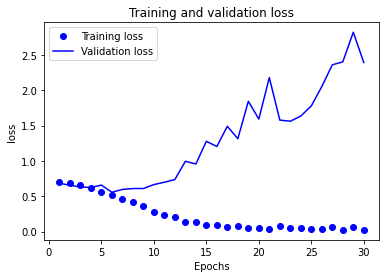

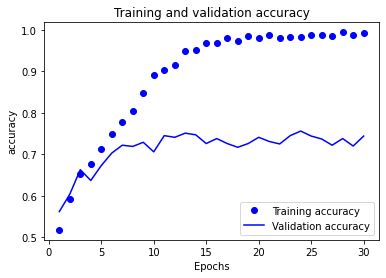

63/63 [==============================] - 2s 27ms/step - loss: 0.5726 - accuracy: 0.7010
test_acc = 0.701


In [11]:
# helper
def train_save_and_eval(model, *, model_name, epochs):
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath=model_name, save_best_only=True, monitor="val_loss")
    ]
    history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset, callbacks=callbacks)
    plot_history(history, variable_name="loss")
    plot_history(history, variable_name="accuracy")

    # load best an check test performance
    test_model = keras.models.load_model(model_name)
    test_loss, test_acc = test_model.evaluate(test_dataset)
    print(f"{test_acc = :.3f}")

train_save_and_eval(model, model_name="covnet_from_scratch.keras", epochs=30)

### Using data augmentation

In [12]:
# define data augmentation layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

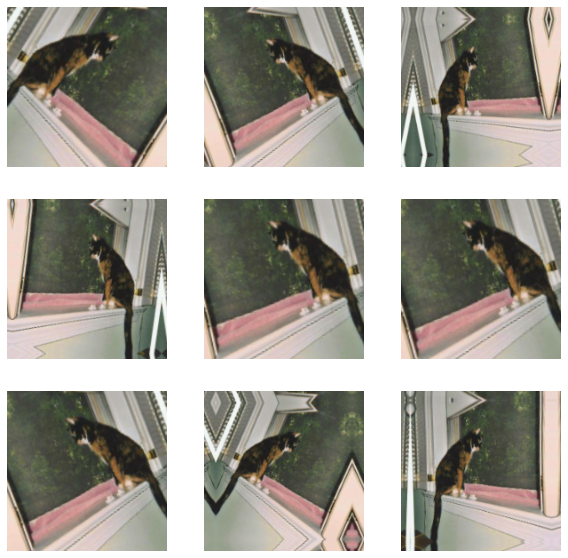

In [13]:
#display
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Epoch 1/100
63/63 [==============================] - 7s 99ms/step - loss: 0.7223 - accuracy: 0.5020 - val_loss: 0.6925 - val_accuracy: 0.6150
Epoch 2/100
63/63 [==============================] - 6s 97ms/step - loss: 0.6945 - accuracy: 0.5195 - val_loss: 0.6809 - val_accuracy: 0.6080
Epoch 3/100
63/63 [==============================] - 6s 97ms/step - loss: 0.6934 - accuracy: 0.5795 - val_loss: 0.6709 - val_accuracy: 0.5610
Epoch 4/100
63/63 [==============================] - 6s 97ms/step - loss: 0.6647 - accuracy: 0.6160 - val_loss: 0.7536 - val_accuracy: 0.5360
Epoch 5/100
63/63 [==============================] - 6s 97ms/step - loss: 0.6464 - accuracy: 0.6375 - val_loss: 0.8825 - val_accuracy: 0.5370
Epoch 6/100
63/63 [==============================] - 6s 97ms/step - loss: 0.6507 - accuracy: 0.6620 - val_loss: 0.7539 - val_accuracy: 0.5980
Epoch 7/100
63/63 [==============================] - 6s 96ms/step - loss: 0.6140 - accuracy: 0.6730 - val_loss: 0.6141 - val_accuracy: 0.6480
Epoch 

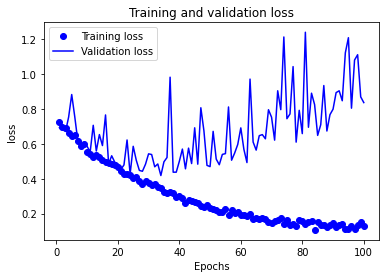

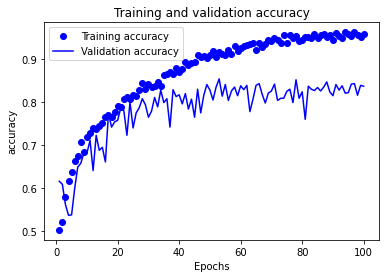

63/63 [==============================] - 2s 28ms/step - loss: 0.4590 - accuracy: 0.8050
test_acc = 0.805


In [14]:
#same as before but with data augmentation
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

# add 4 groups of conv-pool
for f in [32, 64, 128, 256]:
    x = layers.Conv2D(filters=f, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)

# add 1 mere conv and flatten
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

train_save_and_eval(model, model_name="covnet_from_scratch_w_aug.keras", epochs=100)

Epoch 1/100
63/63 [==============================] - 7s 98ms/step - loss: 0.6997 - accuracy: 0.5175 - val_loss: 1.8681 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 6s 96ms/step - loss: 0.7109 - accuracy: 0.5600 - val_loss: 0.6893 - val_accuracy: 0.5120
Epoch 3/100
63/63 [==============================] - 6s 96ms/step - loss: 0.6863 - accuracy: 0.5855 - val_loss: 0.6641 - val_accuracy: 0.5660
Epoch 4/100
63/63 [==============================] - 6s 96ms/step - loss: 0.6629 - accuracy: 0.6235 - val_loss: 0.7001 - val_accuracy: 0.5870
Epoch 5/100
63/63 [==============================] - 6s 96ms/step - loss: 0.6410 - accuracy: 0.6355 - val_loss: 0.6403 - val_accuracy: 0.6360
Epoch 6/100
63/63 [==============================] - 6s 96ms/step - loss: 0.6146 - accuracy: 0.6635 - val_loss: 0.7231 - val_accuracy: 0.5740
Epoch 7/100
63/63 [==============================] - 6s 96ms/step - loss: 0.5966 - accuracy: 0.6785 - val_loss: 0.6231 - val_accuracy: 0.6770
Epoch 

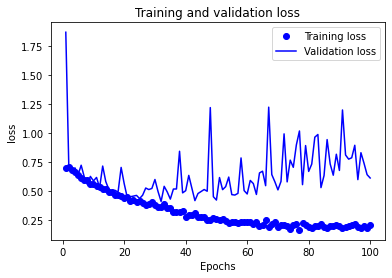

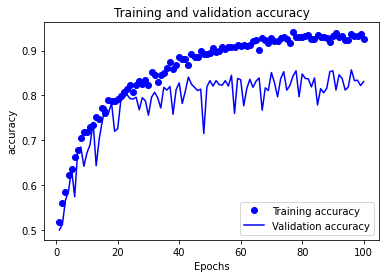

63/63 [==============================] - 2s 27ms/step - loss: 0.4450 - accuracy: 0.8040
test_acc = 0.804


In [15]:
#same as before but with drpout
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

# add 4 groups of conv-pool
for f in [32, 64, 128, 256]:
    x = layers.Conv2D(filters=f, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)

# add 1 mere conv and flatten
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

train_save_and_eval(model, model_name="covnet_from_scratch_w_aug_and_dropout.keras", epochs=100)

## Leverage a pretrained model

### Feature extraction with a pretrained model

In [16]:
conv_base = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(180, 180, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

#### Fast feature extraction without data augmentation

In [17]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in tqdm(dataset):
        processed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(processed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

100%|██████████| 63/63 [00:17<00:00,  3.56it/s]


In [18]:
train_features.shape

(2000, 5, 5, 512)

Epoch 1/20
63/63 [==============================] - 1s 8ms/step - loss: 6.5320 - accuracy: 0.9175 - val_loss: 2.4440 - val_accuracy: 0.9250
Epoch 2/20
63/63 [==============================] - 0s 5ms/step - loss: 0.7702 - accuracy: 0.9690 - val_loss: 0.7670 - val_accuracy: 0.9640
Epoch 3/20
63/63 [==============================] - 0s 5ms/step - loss: 0.4066 - accuracy: 0.9810 - val_loss: 0.3669 - val_accuracy: 0.9770
Epoch 4/20
63/63 [==============================] - 0s 5ms/step - loss: 0.4189 - accuracy: 0.9820 - val_loss: 0.3027 - val_accuracy: 0.9780
Epoch 5/20
63/63 [==============================] - 0s 5ms/step - loss: 0.1683 - accuracy: 0.9900 - val_loss: 0.6320 - val_accuracy: 0.9730
Epoch 6/20
63/63 [==============================] - 0s 5ms/step - loss: 0.1332 - accuracy: 0.9940 - val_loss: 1.0867 - val_accuracy: 0.9670
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 0.3429 - accuracy: 0.9885 - val_loss: 0.5633 - val_accuracy: 0.9730
Epoch 8/20
63/63 [==

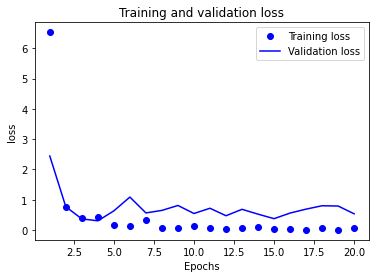

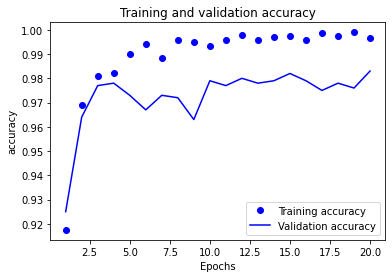

63/63 [==============================] - 0s 2ms/step - loss: 0.5500 - accuracy: 0.9705
test_acc = 0.970


In [19]:
model_name = "feature_extration.keras"

inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=model_name, save_best_only=True, monitor="val_loss")
]
history = model.fit(train_features, train_labels, epochs=20, validation_data=(val_features, val_labels), callbacks=callbacks)
plot_history(history, variable_name="loss")
plot_history(history, variable_name="accuracy")

# load best an check test performance
test_model = keras.models.load_model(model_name)
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"{test_acc = :.3f}")

#### Feature extraction with data augmentation

Epoch 1/50
63/63 [==============================] - 25s 378ms/step - loss: 19.7048 - accuracy: 0.8985 - val_loss: 5.5797 - val_accuracy: 0.9620
Epoch 2/50
63/63 [==============================] - 24s 375ms/step - loss: 8.2557 - accuracy: 0.9425 - val_loss: 3.0380 - val_accuracy: 0.9750
Epoch 3/50
63/63 [==============================] - 24s 376ms/step - loss: 6.0785 - accuracy: 0.9545 - val_loss: 3.7025 - val_accuracy: 0.9760
Epoch 4/50
63/63 [==============================] - 24s 376ms/step - loss: 3.7992 - accuracy: 0.9675 - val_loss: 5.1740 - val_accuracy: 0.9740
Epoch 5/50
63/63 [==============================] - 24s 377ms/step - loss: 4.7280 - accuracy: 0.9600 - val_loss: 5.1288 - val_accuracy: 0.9710
Epoch 6/50
63/63 [==============================] - 24s 376ms/step - loss: 2.5697 - accuracy: 0.9730 - val_loss: 6.1351 - val_accuracy: 0.9730
Epoch 7/50
63/63 [==============================] - 24s 377ms/step - loss: 2.5697 - accuracy: 0.9750 - val_loss: 5.9923 - val_accuracy: 0.965

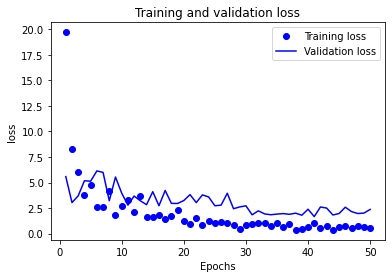

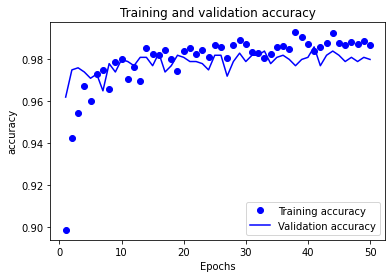

63/63 [==============================] - 16s 242ms/step - loss: 2.1418 - accuracy: 0.9765
test_acc = 0.976


In [20]:
def train_save_and_eval(model, *, model_name, epochs):
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath=model_name, save_best_only=True, monitor="val_loss")
    ]
    history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset, callbacks=callbacks)
    plot_history(history, variable_name="loss")
    plot_history(history, variable_name="accuracy")

    # load best an check test performance
    test_model = keras.models.load_model(model_name)
    test_loss, test_acc = test_model.evaluate(test_dataset)
    print(f"{test_acc = :.3f}")


conv_base = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False)
conv_base.trainable = False

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

train_save_and_eval(model, model_name="feature_extraction_with_data_augmentation.keras", epochs=50)


### Fine-tuning a pretrained model

Epoch 1/30
63/63 [==============================] - 27s 416ms/step - loss: 0.3866 - accuracy: 0.9925 - val_loss: 2.6102 - val_accuracy: 0.9800
Epoch 2/30
63/63 [==============================] - 26s 411ms/step - loss: 0.5851 - accuracy: 0.9880 - val_loss: 1.7812 - val_accuracy: 0.9850
Epoch 3/30
63/63 [==============================] - 26s 410ms/step - loss: 0.3367 - accuracy: 0.9905 - val_loss: 1.6246 - val_accuracy: 0.9840
Epoch 4/30
63/63 [==============================] - 26s 411ms/step - loss: 0.3786 - accuracy: 0.9935 - val_loss: 1.4583 - val_accuracy: 0.9820
Epoch 5/30
63/63 [==============================] - 26s 412ms/step - loss: 0.3108 - accuracy: 0.9930 - val_loss: 1.9211 - val_accuracy: 0.9840
Epoch 6/30
63/63 [==============================] - 26s 410ms/step - loss: 0.3157 - accuracy: 0.9915 - val_loss: 2.4410 - val_accuracy: 0.9760
Epoch 7/30
63/63 [==============================] - 26s 411ms/step - loss: 0.4982 - accuracy: 0.9860 - val_loss: 1.9369 - val_accuracy: 0.9800

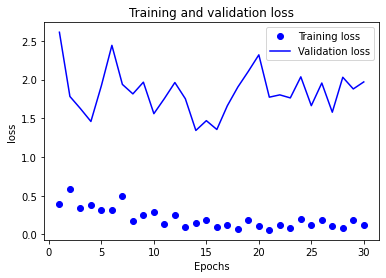

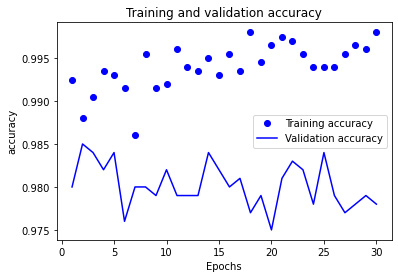

63/63 [==============================] - 15s 242ms/step - loss: 1.5664 - accuracy: 0.9785
test_acc = 0.979


In [21]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), loss="binary_crossentropy", metrics=["accuracy"])

train_save_and_eval(model, model_name="fine_tuning.keras", epochs=30)